In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             recall_score, classification_report, 
                             confusion_matrix, roc_curve)
from sklearn.preprocessing import LabelEncoder

import shap
import dice_ml

c:\Users\User\anaconda3\envs\tf210\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('whitegrid')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

In [3]:
# 1. Data Loading & Preprocessing
df = pd.read_csv("german_credit_data.csv") 

df = df.iloc[:, 1:] 

df['Risk'] = df['Risk'].map({'bad': 1, 'good': 0})

print(f"Data shape: {df.shape}")
print("Column names:", df.columns.tolist())
print("-" * 50)

Data shape: (1000, 10)
Column names: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']
--------------------------------------------------


Starting EDA Analysis


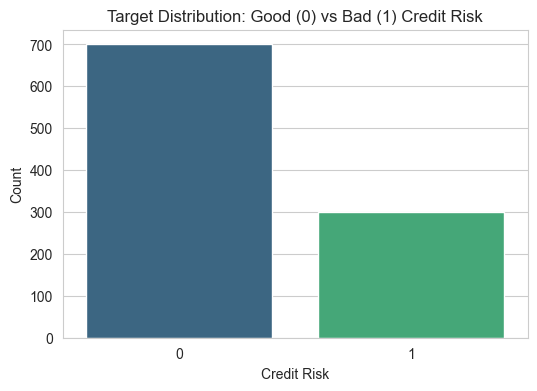

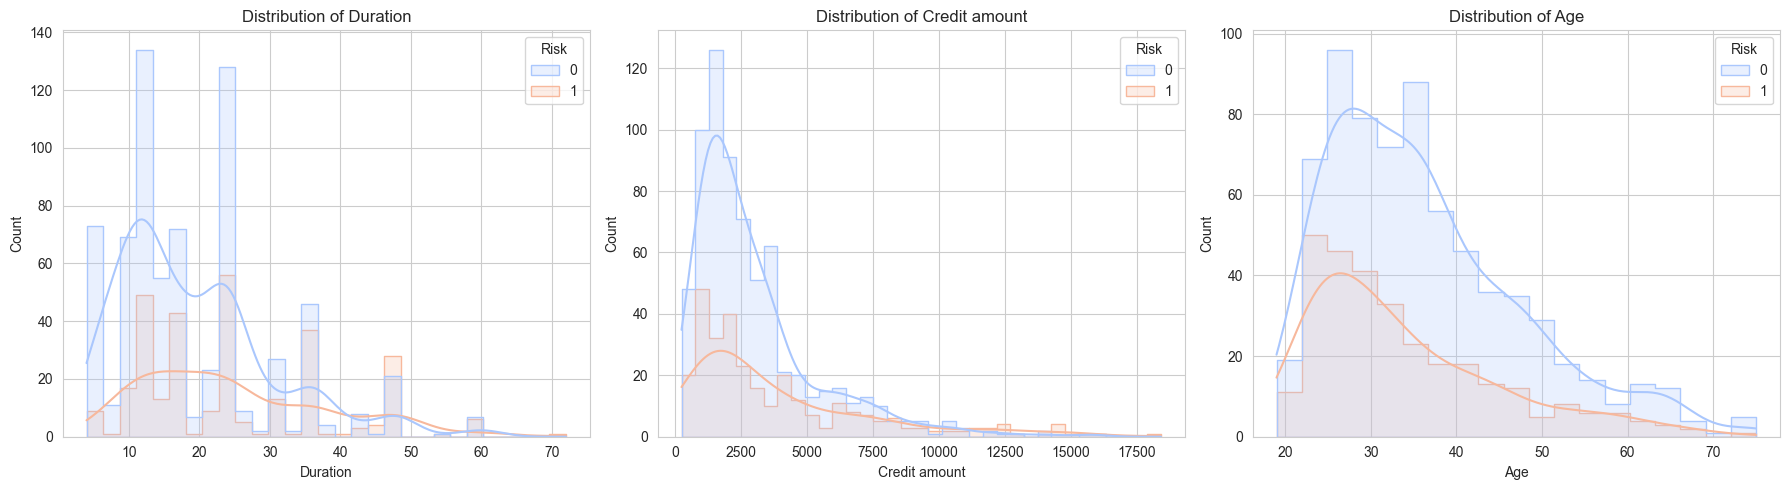


Categorical Features and Their Attributes:
         Feature  Unique Count                                                                                                 Values
             Sex             2                                                                                           female, male
             Job             4                                                                                             0, 1, 2, 3
         Housing             3                                                                                        free, own, rent
 Saving accounts             4                                                                     little, moderate, quite rich, rich
Checking account             3                                                                                 little, moderate, rich
         Purpose             8 business, car, domestic appliances, education, furniture/equipment, radio/TV, repairs, vacation/others

-----------------

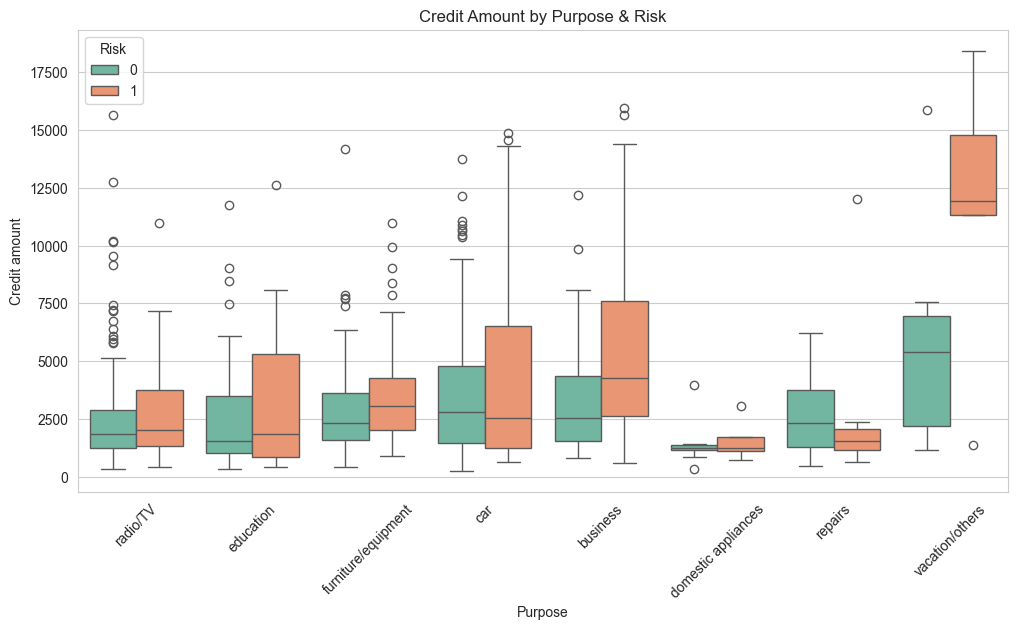

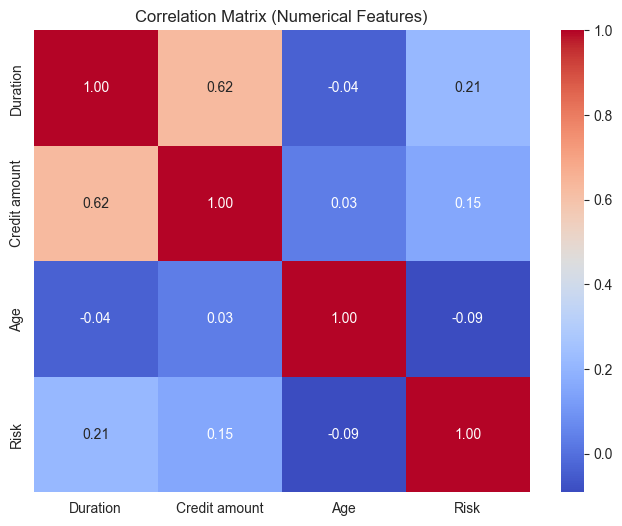

--------------------------------------------------


In [ ]:
# 2. Exploratory Data Analysis (EDA)
print("Starting EDA Analysis")

# 2.1 Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Risk', data=df, palette='viridis')
plt.title('Target Distribution: Good (0) vs Bad (1) Credit Risk')
plt.xlabel('Credit Risk')
plt.ylabel('Count')
plt.show()

# 2.2 Numerical Variables Distribution
num_features = ['Duration', 'Credit amount', 'Age']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(num_features):
    sns.histplot(data=df, x=col, hue='Risk', kde=True, element="step", ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 2.2b Categorical Features Attributes
print("\nCategorical Features and Their Attributes:")
cat_features = [col for col in df.columns if col not in num_features and col != 'Risk']

# Create a summary table
cat_summary = []
for col in cat_features:
    unique_count = df[col].nunique()
    unique_vals = sorted([v for v in df[col].unique() if pd.notna(v)])
    cat_summary.append({
        'Feature': col,
        'Unique Count': unique_count,
        'Values': ', '.join(map(str, unique_vals[:10]))  # Show first 10 values
    })

cat_summary_df = pd.DataFrame(cat_summary)
print(cat_summary_df.to_string(index=False))
print("\n" + "-" * 50)

# Detailed value counts for each categorical feature
for col in cat_features:
    print(f"\n{col} - Value Distribution:")
    value_counts = df[col].value_counts(dropna=False)
    for val, count in value_counts.items():
        print(f"  {val}: {count}")

print("\n" + "-" * 50)

# 2.3 Categorical Variables Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='Purpose', y='Credit amount', hue='Risk', data=df, palette='Set2')
plt.title('Credit Amount by Purpose & Risk')
plt.xticks(rotation=45)
plt.show()

# 2.4 Correlation Matrix
plt.figure(figsize=(8, 6))
corr = df[num_features + ['Risk']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

print("-" * 50)

In [5]:
# 3. Feature Engineering

# Label Encoding for Categorical Features
from sklearn.preprocessing import MinMaxScaler

target_col = "Risk"
exclude_cols = [target_col, "Credit amount", "Age", "Duration"]
categorical_cols = [c for c in df.columns if c not in exclude_cols]

# Initialize label encoders dictionary
label_encoders = {}

# Encode target variable
label_encoders['Risk'] = LabelEncoder()
df[target_col] = label_encoders['Risk'].fit_transform(df[target_col])

# Encode categorical features
df_encoded = df.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Scaling (only numerical features)
scaler = MinMaxScaler()
scale_cols = ["Credit amount", "Age", "Duration"]
df_encoded[scale_cols] = scaler.fit_transform(df_encoded[scale_cols])

# Data Split
X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Feature engineering completed!")
print(f"Encoded features shape: {df_encoded.shape}")
print(f"Label encoders created for: {list(label_encoders.keys())}")
print(f"Scaled columns: {scale_cols}")

Feature engineering completed!
Encoded features shape: (1000, 10)
Label encoders created for: ['Risk', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
Scaled columns: ['Credit amount', 'Age', 'Duration']


In [6]:
# 4. Model Training Preparation & Data Splitting
print("Step 2. Performing Data Splitting (60% Train, 20% Val, 20% Test)")

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"   Train set shape: {X_train.shape}")
print(f"   Val   set shape: {X_val.shape}")
print(f"   Test  set shape: {X_test.shape}")

count_0 = (y_train == 0).sum()
count_1 = (y_train == 1).sum()
weight_ratio = count_0 / count_1
print(f"   Auto-calculated scale_pos_weight: {weight_ratio:.2f}")
print(f"   Label encoders available: {list(label_encoders.keys())}")


Step 2. Performing Data Splitting (60% Train, 20% Val, 20% Test)
   Train set shape: (600, 9)
   Val   set shape: (200, 9)
   Test  set shape: (200, 9)
   Auto-calculated scale_pos_weight: 2.33
   Label encoders available: ['Risk', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']



Step 3. Starting GridSearchCV (this may take a few minutes)
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

 Grid Search completed!
   Best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 3.5, 'subsample': 0.7}
   Best validation F1 score: 0.5930

Step 4. Training final model with early stopping


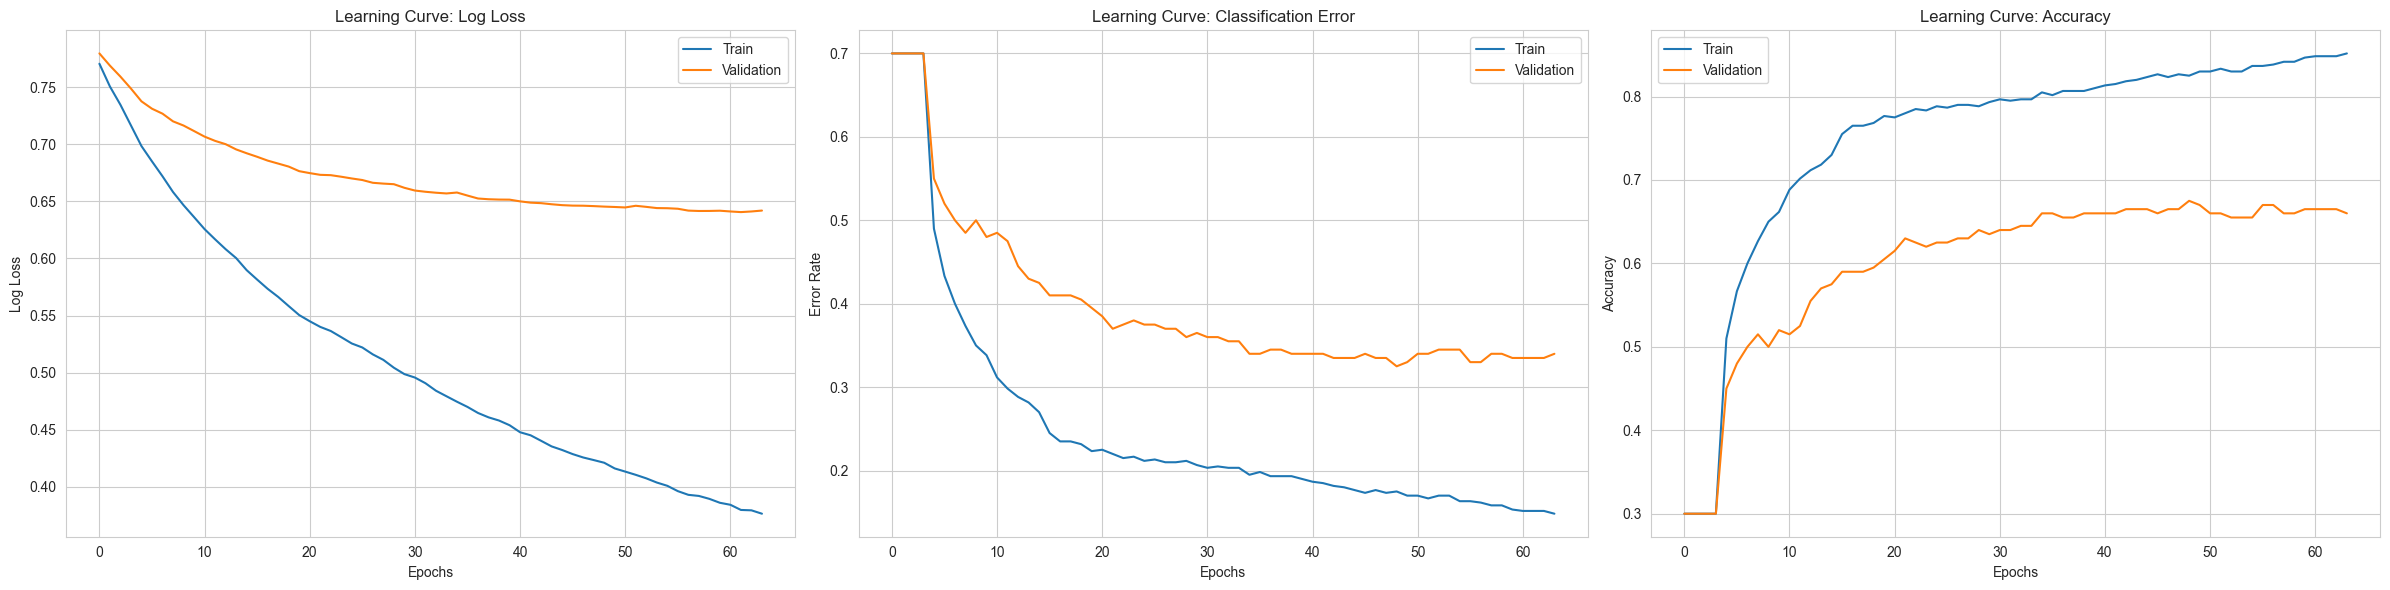

In [7]:
print("\nStep 3. Starting GridSearchCV (this may take a few minutes)")

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.075, 0.1, 0.15],
    'n_estimators': [200, 300, 400],
    'scale_pos_weight': [1, weight_ratio, weight_ratio * 1.5],
    'subsample': [0.6, 0.7, 0.8, 1.0]
}

xgb = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss', 
    use_label_encoder=False, 
    random_state=42
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\n Grid Search completed!")
print(f"   Best params: {grid_search.best_params_}")
print(f"   Best validation F1 score: {grid_search.best_score_:.4f}")

# 5. Train Final Model with Early Stopping
print("\nStep 4. Training final model with early stopping")

best_params = grid_search.best_params_

xgb_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric=['logloss', 'error'], 
    early_stopping_rounds=15, 
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

# 6. Visualization Results
results = xgb_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(1, 3, figsize=(24, 6))

# Log Loss Curve
ax[0].plot(x_axis, results['validation_0']['logloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax[0].legend()
ax[0].set_title('Learning Curve: Log Loss')
ax[0].set_ylabel('Log Loss')
ax[0].set_xlabel('Epochs')

# Classification Error Curve
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Validation')
ax[1].legend()
ax[1].set_title('Learning Curve: Classification Error')
ax[1].set_ylabel('Error Rate')
ax[1].set_xlabel('Epochs')

# Accuracy Curve
train_acc = [1 - x for x in results['validation_0']['error']]
val_acc = [1 - x for x in results['validation_1']['error']]

ax[2].plot(x_axis, train_acc, label='Train')
ax[2].plot(x_axis, val_acc, label='Validation')
ax[2].legend()
ax[2].set_title('Learning Curve: Accuracy')
ax[2].set_ylabel('Accuracy')
ax[2].set_xlabel('Epochs')

plt.tight_layout()
plt.show()


Model Evaluation Results (XGBoost):
Accuracy : 0.7050
ROC AUC  : 0.7988
F1 Score : 0.5874
Recall   : 0.7000
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       140
           1       0.51      0.70      0.59        60

    accuracy                           0.70       200
   macro avg       0.68      0.70      0.68       200
weighted avg       0.74      0.70      0.72       200



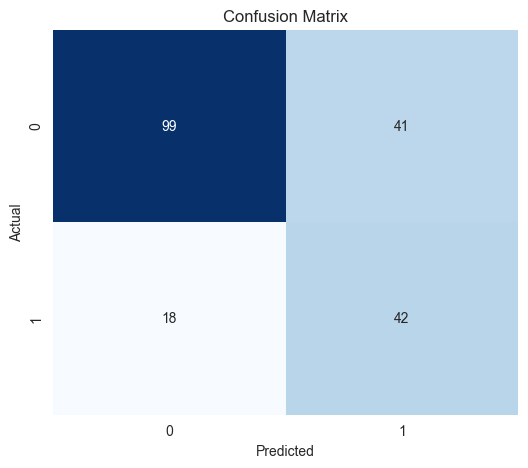

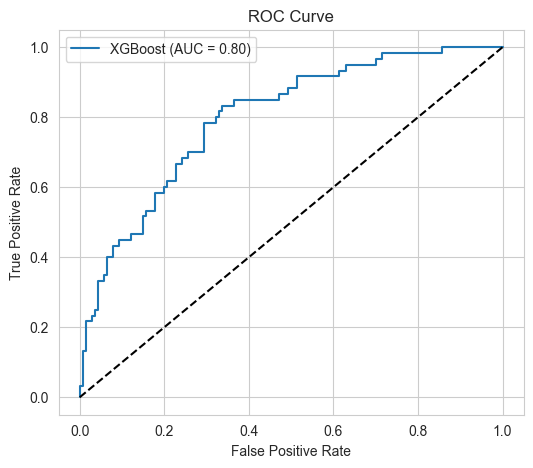

In [8]:
# 7. Model Evaluation
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nModel Evaluation Results (XGBoost):")
print(f"Accuracy : {acc:.4f}")
print(f"ROC AUC  : {auc:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Recall   : {recall:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


[Task 3] Computing SHAP values


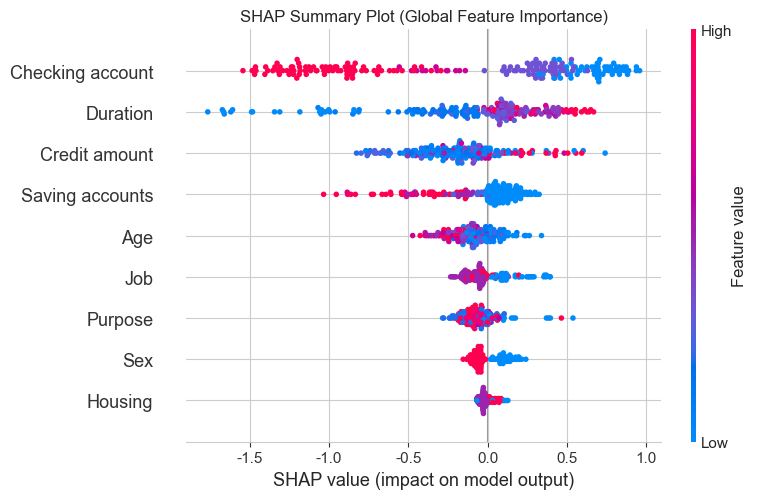

Interpretation: Heatmap shows feature importance variations across samples.


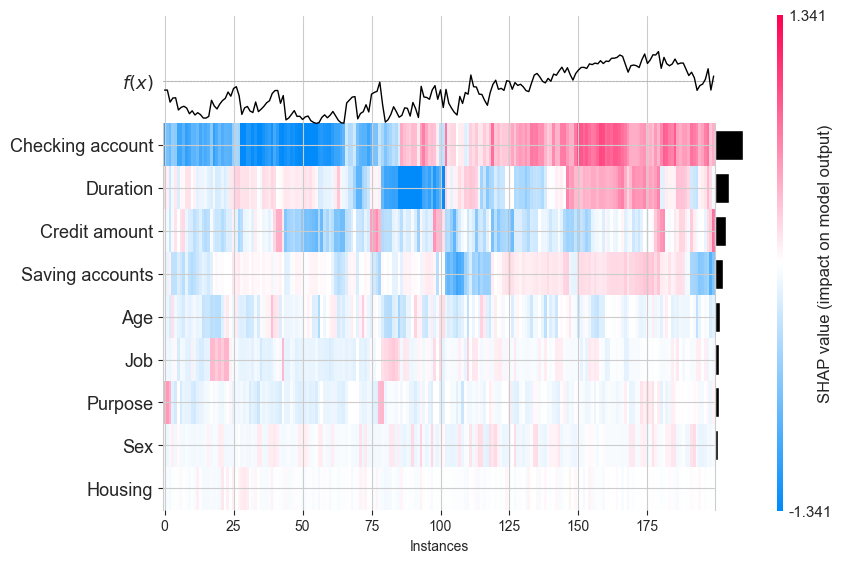


Local Explanation - Sample ID: 1


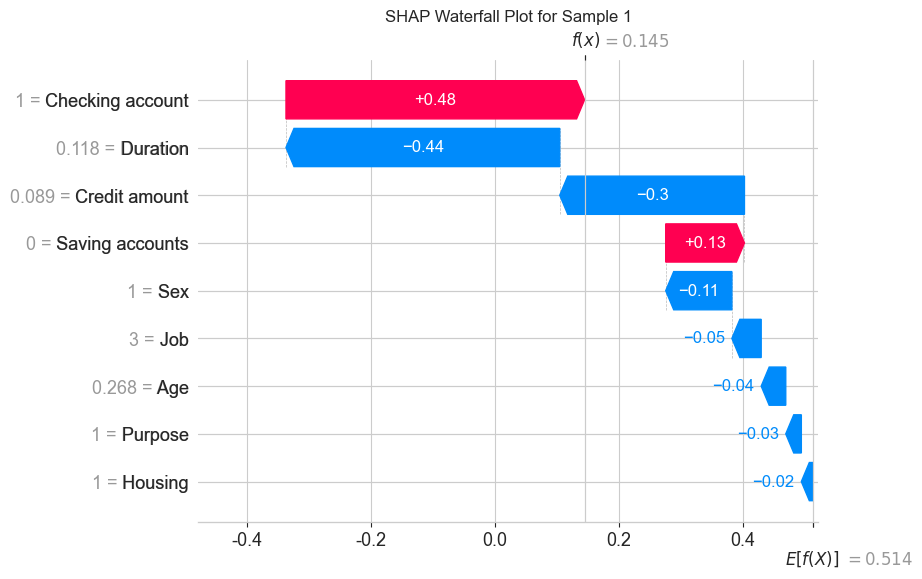


[Task 3] Generating DiCE counterfactual explanations


In [9]:
# 8. XAI Applications (SHAP & DiCE)
best_model = xgb_model

# 8.1 SHAP
print("\n[Task 3] Computing SHAP values")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
plt.figure(figsize=(10, 6))
plt.title("SHAP Summary Plot (Global Feature Importance)")
shap.summary_plot(shap_values, X_test, show=False)
plt.show()

# Heatmap
print("Interpretation: Heatmap shows feature importance variations across samples.")
plt.figure(figsize=(10, 6))
shap_exp = shap.Explanation(shap_values, data=X_test, feature_names=X_test.columns)
shap.plots.heatmap(shap_exp)
plt.show()

# Local Explanation
bad_indices = np.where(y_pred == 1)[0]
if len(bad_indices) > 0:
    target_idx = bad_indices[0]
    print(f"\nLocal Explanation - Sample ID: {target_idx}")
    
    plt.figure(figsize=(8, 8))
    shap_exp = shap.Explanation(values=shap_values[target_idx], 
                                base_values=explainer.expected_value, 
                                data=X_test.iloc[target_idx],
                                feature_names=X_test.columns)
    shap.plots.waterfall(shap_exp, show=False)
    plt.title(f"SHAP Waterfall Plot for Sample {target_idx}")
    plt.show()
else:
    print("No Bad Credit predictions found in test set.")

# 8.2 DiCE (Counterfactuals)
print("\n[Task 3] Generating DiCE counterfactual explanations")

In [10]:
# ModelWrapper
class ModelWrapper:
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        return self.model.predict(X.apply(pd.to_numeric, errors='coerce').fillna(0))
    def predict_proba(self, X):
        return self.model.predict_proba(X.apply(pd.to_numeric, errors='coerce').fillna(0))

wrapped_model = ModelWrapper(best_model)

# Only original numerical features are available
continuous_features = ['Credit amount', 'Age', 'Duration']
continuous_features = [col for col in continuous_features if col in df_encoded.columns]

print(f"DiCE continuous features: {continuous_features}")

d = dice_ml.Data(
    dataframe=df_encoded, 
    continuous_features=continuous_features, 
    outcome_name='Risk'
)

m = dice_ml.Model(model=wrapped_model, backend="sklearn")
exp_dice = dice_ml.Dice(d, m, method="random")

# Only vary features that exist in the training data
features_to_vary = ['Credit amount', 'Age', 'Duration']

if len(bad_indices) > 0:
    query_instance = X_test.iloc[[target_idx]]
    
    print(f"Generating counterfactual explanations for sample {target_idx}")
    
    dice_result = exp_dice.generate_counterfactuals(
        query_instance, 
        total_CFs=3, 
        desired_class="opposite",
        features_to_vary=features_to_vary 
    )
    
    dice_result.visualize_as_dataframe(show_only_changes=True)
else:
    print("No Bad Credit samples found. Skipping DiCE generation.")

DiCE continuous features: ['Credit amount', 'Age', 'Duration']
Generating counterfactual explanations for sample 1


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

Query instance (original outcome : 1)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0.267857,1,3,1,0,1,0.088588,0.117647,1,1



Diverse Counterfactual set (new outcome: 0)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0.55659621,-,-,-,-,-,-,-,-,0.0
1,0.98449885,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,0.07267341,-,0.0


In [11]:
# 9. Task 4: Knowledge Summary
print("Task 4: Knowledge Assessment Summary")
print("""
1. Concept-based vs Counterfactual vs Feature-based:
   - Feature-based (SHAP): Shows which input features contribute most to predictions.
   - Counterfactual (DiCE): Shows how to change inputs to alter predictions.
   - Concept-based: Explains abstract concepts (e.g., patterns in images).

2. Interpretable Complex Models:
   - XGBoost (used here): Complex model with high accuracy, captures non-linear relationships, requires SHAP for interpretation.
   - Intrinsic Interpretable Models (GAMs, EBM): Built-in interpretability, direct feature relationships, sometimes lower accuracy than XGBoost.
""")

# 10. Save Model Components
print("\nSaving model components for Streamlit")
joblib.dump(best_model, 'xgb_model.pkl')
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("✓ All files saved successfully:")
print("  - xgb_model.pkl (trained XGBoost model)")
print("  - X_train.pkl (training features)")
print("  - X_test.pkl (test features)")
print("  - label_encoders.pkl (LabelEncoder dictionary)")
print("  - scaler.pkl (MinMaxScaler for numerical features)")


Task 4: Knowledge Assessment Summary

1. Concept-based vs Counterfactual vs Feature-based:
   - Feature-based (SHAP): Shows which input features contribute most to predictions.
   - Counterfactual (DiCE): Shows how to change inputs to alter predictions.
   - Concept-based: Explains abstract concepts (e.g., patterns in images).

2. Interpretable Complex Models:
   - XGBoost (used here): Complex model with high accuracy, captures non-linear relationships, requires SHAP for interpretation.
   - Intrinsic Interpretable Models (GAMs, EBM): Built-in interpretability, direct feature relationships, sometimes lower accuracy than XGBoost.


Saving model components for Streamlit
✓ All files saved successfully:
  - xgb_model.pkl (trained XGBoost model)
  - X_train.pkl (training features)
  - X_test.pkl (test features)
  - label_encoders.pkl (LabelEncoder dictionary)
  - scaler.pkl (MinMaxScaler for numerical features)
